# Classification with the Adult dataset

### Author: Marcel Rodrigues de Barros
### NUSP: 5947197

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [80]:
adults = pd.read_csv("data/adult.data", header=None)
adults.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race",
"sex","capital-gain","capital-loss","hours-per-week","native-country","income"]

adults_test = pd.read_csv("data/adult.test", header=None,skiprows=1)
adults_test.columns = ["age", "workclass", "fnlwgt", "education", "education-num", "marital-status", "occupation", "relationship", "race",
"sex","capital-gain","capital-loss","hours-per-week","native-country","income"]

In [81]:
# map >50k to 1 and <=50k to 0
adults['income']=adults['income'].map({' <=50K': 0, ' >50K': 1})
adults_test['income']=adults_test['income'].map({' <=50K.': 0, ' >50K.': 1})


In [82]:
numeric_features = ['age','fnlwgt','education-num','capital-gain','capital-loss','hours-per-week','income']

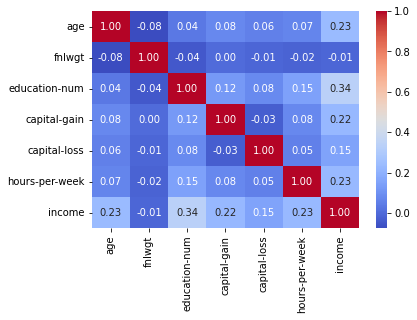

In [83]:
g = sns.heatmap(adults[numeric_features].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

'fnlwgt' field is a weight that represents how many people can be described by the respective row. It does not correlate to 'income' as shown above and can be discarded.

Also, 'education' is just the text version of 'education-num' and can also be dropped.

In [84]:
adults.drop(columns=["fnlwgt","education"],inplace=True)
adults_test.drop(columns=["fnlwgt","education"],inplace=True)
numeric_features = ['age','education-num','capital-gain','capital-loss','hours-per-week']
cat_features = ['workclass','marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
adults.describe()

,age,education-num,capital-gain,capital-loss,hours-per-week,income
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000,1.000000


'capital-loss' and 'capital-gain' are mostly zeros.
To handle this I'll create an auxiliary column with that info for each.

In [85]:
adults["capital_loss_filled"] = (adults["capital-loss"]!=0)
adults["capital_gain_filled"] = (adults["capital-gain"]!=0)
adults_test["capital_loss_filled"] = (adults_test["capital-loss"]!=0)
adults_test["capital_gain_filled"] = (adults_test["capital-gain"]!=0)
cat_features.extend(["capital_loss_filled","capital_gain_filled"])
adults.head()

,age,workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,capital_loss_filled,capital_gain_filled
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0,False,True
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0,False,False
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0,False,False
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0,False,False
4,28,Private,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0,False,False


<AxesSubplot:ylabel='Density'>

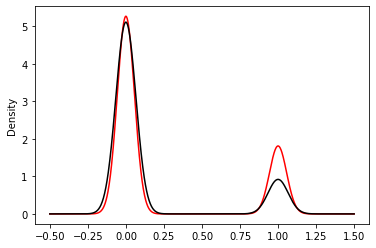

In [86]:
# Income vs Race
adults[adults["race"]==" White"]["income"].plot.kde(color="red")
adults[adults["race"]!=" White"]["income"].plot.kde(color="black")

Kernel density plot above shows that it is much more common (relative to sample size) for white people to earn more than 50K.

<AxesSubplot:ylabel='Density'>

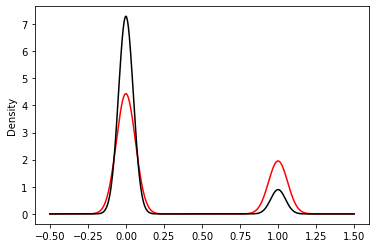

In [87]:
# Income vs Sex
adults[adults["sex"]==" Male"]["income"].plot.kde(color="red")
adults[adults["sex"]==" Female"]["income"].plot.kde(color="black")

Kernel density plot above shows that it is much more common (relative to sample size) for men to earn more than 50K compared to women (biological sex).

In [88]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


In [89]:
# One hot encoding for categorical features
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(adults[cat_features])
x_cat = enc.transform(adults[cat_features]).toarray()
x_cat_test = enc.transform(adults_test[cat_features]).toarray()

In [90]:
# Normalize numeric features
enc = StandardScaler()
enc.fit(adults[numeric_features])
x_num = enc.transform(adults[numeric_features])
x_num_test = enc.transform(adults_test[numeric_features])

In [91]:
x_train = np.concatenate((x_num, x_cat), axis=1)
x_test = np.concatenate((x_num_test, x_cat_test), axis=1)
y_train = adults["income"].to_numpy()
y_test = adults_test["income"].to_numpy()
results = []

In [92]:
# Defining n_neighbors in KNN
best_result= None
for n_neighbors in range(23,28):
    knn_model = KNeighborsClassifier(n_neighbors=n_neighbors)
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(knn_model, x_train, y_train, cv=kfold, scoring='accuracy')
    print(f"n_neighbors={n_neighbors}: {cv_results.mean()} ({cv_results.std()})")
    if best_result is None or cv_results.mean()>best_result.mean():
        best_result = cv_results
        best_n_neighbors = n_neighbors

print(f"Best n_neighbors={best_n_neighbors} with {best_result.mean()}")
knn_model = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_model.fit(x_train, y_train)
print(f"Test set accuracy: {knn_model.score(x_test,y_test)}")
results.append(best_result)
print(classification_report(y_test, knn_model.predict(x_test)))
    

n_neighbors=23: 0.852308150661444 (0.0033611682886074963)
n_neighbors=24: 0.8524002693912873 (0.003694764244628697)
n_neighbors=25: 0.8516324466923268 (0.0031250256638698914)
n_neighbors=26: 0.8524923881211306 (0.003444713503125383)
n_neighbors=27: 0.8514482092326403 (0.0036436057450115883)
Best n_neighbors=26 with 0.8524923881211306
Test set accuracy: 0.8520361157177078
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     12435
           1       0.72      0.61      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.77      0.78     16281
weighted avg       0.85      0.85      0.85     16281



In [93]:
# Defining number of trees in random forest
best_result = None
for n_estimators in range(150,200,20):
    rf_model = RandomForestClassifier(n_estimators=n_estimators)
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(rf_model, x_train, y_train, cv=kfold, scoring='accuracy')
    print(f"n_estimators={n_estimators}: {cv_results.mean()} ({cv_results.std()})")
    if best_result is None or cv_results.mean()>best_result.mean():
        best_result = cv_results
        best_n_estimators = n_estimators
print(f"Best n_estimators={best_n_estimators} with {best_result.mean()}")
rf_model = RandomForestClassifier(n_estimators=best_n_estimators)
rf_model.fit(x_train, y_train)
print(f"Test set accuracy: {rf_model.score(x_test,y_test)}")
results.append(best_result)
print(classification_report(y_test, rf_model.predict(x_test)))

n_estimators=150: 0.8501274666693828 (0.0013890693783490538)
n_estimators=170: 0.8502810104606512 (0.0012169642710233618)
n_estimators=190: 0.8504959698821974 (0.002037917563317131)
Best n_estimators=190 with 0.8504959698821974
Test set accuracy: 0.8498249493274369
              precision    recall  f1-score   support

           0       0.89      0.92      0.90     12435
           1       0.71      0.61      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.80      0.77      0.78     16281
weighted avg       0.84      0.85      0.85     16281



In [94]:
# Defining var_smoothing for Gaussian Naive Bayes
best_result = None
for var_smoothing in [1e-10,1e-9,1e-7,1e-5,1e-3,1e-1,1,10,100,1000]:
    nb_model = GaussianNB(var_smoothing=var_smoothing)
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(nb_model, x_train, y_train, cv=kfold, scoring='accuracy')
    print(f"var_smoothing={var_smoothing}: {cv_results.mean()} ({cv_results.std()})")
    if best_result is None or cv_results.mean()>best_result.mean():
        best_result = cv_results
        best_var_smoothing = var_smoothing
print(f"Best var_smoothing={best_var_smoothing} with {best_result.mean()}")
nb_model = GaussianNB(var_smoothing=best_var_smoothing)
nb_model.fit(x_train, y_train)
print(f"Test set accuracy: {nb_model.score(x_test,y_test)}")
results.append(best_result)
print(classification_report(y_test, nb_model.predict(x_test)))

var_smoothing=1e-10: 0.5190573681591646 (0.017766797257113734)
var_smoothing=1e-09: 0.5365629400809041 (0.01773669234443835)
var_smoothing=1e-07: 0.5799889259470098 (0.011768454137920388)
var_smoothing=1e-05: 0.6516697468793277 (0.013571335879404074)
var_smoothing=0.001: 0.7510826579688856 (0.0027435828307859874)
var_smoothing=0.1: 0.8135808424730581 (0.0046106761649630885)
var_smoothing=1: 0.79337245467485 (0.0037901215830541597)
var_smoothing=10: 0.7640736151963697 (0.0034842940926619326)
var_smoothing=100: 0.7591904595647111 (0.003202812087717128)
var_smoothing=1000: 0.7591904595647111 (0.003202812087717128)
Best var_smoothing=0.1 with 0.8135808424730581
Test set accuracy: 0.811068116209078
              precision    recall  f1-score   support

           0       0.91      0.83      0.87     12435
           1       0.58      0.74      0.65      3846

    accuracy                           0.81     16281
   macro avg       0.75      0.79      0.76     16281
weighted avg       0.83  

In [95]:
# Defining logisticregression penalty
best_result = None
for penalty in ["l2","none"]:
    log_model = LogisticRegression(penalty=penalty,max_iter=10000,tol=0.1)
    kfold = KFold(n_splits=5)
    cv_results = cross_val_score(log_model, x_train, y_train, cv=kfold, scoring='accuracy')
    print(f"penalty={penalty}: {cv_results.mean()} ({cv_results.std()})")
    if best_result is None or cv_results.mean()>best_result.mean():
        best_result = cv_results
        best_penalty = penalty
print(f"Best penalty={best_penalty} with {best_result.mean()}")
log_model = LogisticRegression(penalty=best_penalty,max_iter=10000)
log_model.fit(x_train, y_train)
print(f"Test set accuracy: {log_model.score(x_test,y_test)}")
results.append(best_result)
print(classification_report(y_test, log_model.predict(x_test)))

penalty=l2: 0.8551642368259135 (0.003161723845542175)
penalty=none: 0.8547649975045186 (0.003363565864134765)
Best penalty=l2 with 0.8551642368259135
Test set accuracy: 0.8554757078803513
              precision    recall  f1-score   support

           0       0.88      0.93      0.91     12435
           1       0.74      0.60      0.66      3846

    accuracy                           0.86     16281
   macro avg       0.81      0.77      0.79     16281
weighted avg       0.85      0.86      0.85     16281



In [98]:
#simple MLP
from sklearn.neural_network import MLPClassifier
best_result = None
for layers in range(2,4):
    for layer_size in range(30,50,10):
        layers_desc = [layer_size]*layers
        mlp_model = MLPClassifier(hidden_layer_sizes=layers_desc,tol=0.5)
        kfold = KFold(n_splits=5)
        cv_results = cross_val_score(mlp_model, x_train, y_train, cv=kfold, scoring='accuracy')
        print(f"layer_desc={layers_desc}: {cv_results.mean()} ({cv_results.std()})")
        if best_result is None or cv_results.mean()>best_result.mean():
            best_result = cv_results
            best_layers = layers_desc
print(f"Best layers={best_layers} with {best_result.mean()}")
mlp_model = MLPClassifier(hidden_layer_sizes=best_layers,tol=0.5)
mlp_model.fit(x_train, y_train)
print(f"Test set accuracy: {mlp_model.score(x_test,y_test)}")
results.append(best_result)
print(classification_report(y_test, mlp_model.predict(x_test)))

layer_desc=[30, 30]: 0.8582353342832384 (0.0015561412145742842)
layer_desc=[40, 40]: 0.8585425444706882 (0.002089369399556255)
layer_desc=[30, 30, 30]: 0.8571298152136475 (0.003635059889458654)
layer_desc=[40, 40, 40]: 0.8578362081356093 (0.0031677473592985885)
Best layers=[40, 40] with 0.8585425444706882
Test set accuracy: 0.8602665683926048
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     12435
           1       0.76      0.59      0.67      3846

    accuracy                           0.86     16281
   macro avg       0.82      0.77      0.79     16281
weighted avg       0.85      0.86      0.85     16281



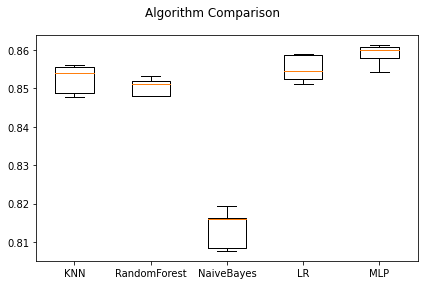

In [97]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(["KNN", "RandomForest", "NaiveBayes", "LR", "MLP"])
plt.tight_layout()

### Conclusion
As shown, the classification using one-hot encoding for categorical features and Z-score scaling for numeric feature achieve above 85% accuracy for all classifiers, except for NaiveBayes.

Feature analysis show the discrepancy between income for women vs men and for white vs non-white citizens.
